<a href="https://colab.research.google.com/github/Piyush01Bhatt/Deep-Learning/blob/master/Tensorflow_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [25]:
tf.__version__

'1.13.0-rc0'

**Loading The MNIST Handwritten digit dataset**

In [0]:
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

In [27]:
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Size of training set = {X_train.shape[0]}')
print(f'Size of test set = {X_test.shape[0]}')

Shape of X_train = (60000, 28, 28)
Shape of y_train = (60000,)
Size of training set = 60000
Size of test set = 10000


In [28]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# size of flatten image
img_size_flat = 28 * 28

# shape of image
img_shape = (28,28)

# number of classes [0-9]
num_classes = 10

**One hot encoding the test and train labels**

In [0]:
y_train_encoded = np.eye(num_classes)[y_train] 
y_test_encoded = np.eye(num_classes)[y_test] 

In [31]:
print(f'Y_train_encoded shape = {y_train_encoded.shape}')
print(f'Y_test_encoded shape = {y_test_encoded.shape}')

Y_train_encoded shape = (60000, 10)
Y_test_encoded shape = (10000, 10)


In [32]:
y_train_encoded[0:5, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [33]:
y_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

**Helper function for plotting images**

In [0]:
def plot_images(images, cls_true, cls_pred=None):
  assert len(images) == len(cls_true) == 9
  
  # Create figure with 3x3 sub-plots
  f,ax = plt.subplots(3, 3)
  f.subplots_adjust(hspace=0.3, wspace=0.3)
  
  for i, ax in enumerate(ax.flat):
    # Plot image
    ax.imshow(images[i].reshape(img_shape), cmap='binary')
    
    # Show true and predicted classes
    if cls_pred is None:
      xlabel = 'True: {0}'.format(cls_true[i])
    else:
      xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
    
    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)
    
    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])
    
  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell
  plt.show()

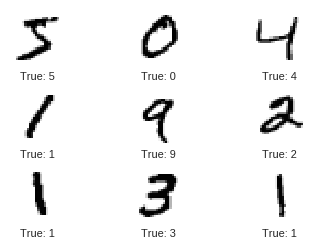

In [35]:
images = X_train[0:9]
cls_true = y_train[0:9]
plot_images(images=images, cls_true=cls_true)

**Tensorflow Graph**

A TensorFlow graph consists of the following parts which will be detailed below:

  1. Placeholder variables used to feed input into the graph.
  2. Model variables that are going to be optimized so as to make the model perform better.
  3. The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
  4. A cost measure that can be used to guide the optimization of the variables.
  5. An optimization method which updates the variables of the model.

**1> Placeholder Variables**

These serve as input to the tensor graph whose value may change

In [0]:
# placeholder for input images
x = tf.placeholder(tf.float32, [None, img_size_flat])
# None is telling the tensor that this dimension is variable
# As while training in batches any amount of input can be used
# [None,784]

In [0]:
# placeholder for output variable
y_true = tf.placeholder(tf.float32, [None, num_classes])
# [None, 10]

In [0]:
y_true_cls = tf.placeholder(tf.int64, [None])
#This is a 1-d vector of true class labels

**Variables to be optimised**

In [0]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

**Model**

In [0]:
# y = x * w + b

logits = tf.matmul(x, weights) + biases

In [0]:
# it is a way of normalising by making sum of inputs = 1
y_pred = tf.nn.softmax(logits)

In [0]:
# finding the maximum score in logits array
y_pred_cls = tf.argmax(y_pred, axis=1)

**Cost function to be optimized**


To make the model better at classifying the input images, we must somehow change the variables for weights and biases. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications

In [0]:
cost = tf.reduce_mean(cross_entropy)

**Optimization**

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

**Performance Measures**

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**Running the tensorflow**

In [0]:
# Running the tensorflow graph in a tensorflow session
session = tf.Session()

**Initialize variables**

In [0]:
# variables weights and biases must be initialised before optimization
session.run(tf.global_variables_initializer())

**Helper function to get train in batches**

In [0]:
train_batch_size = 100

In [0]:

# Helper function for getting batch size
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

**Helper function for optimization iterations**

In [0]:
def optimize(num_iterations):
  for i in range(num_iterations):
    #get batch
    x_batch, y_true_batch = next_batch(num = train_batch_size,
                                       data = X_train,
                                       labels = y_train_encoded)
    #setting placeholder values
    feed_dict_train = {
        x : x_batch.reshape(-1,784),
        y_true: y_true_batch
    }
    
    #running optimizer
    session.run(optimizer, feed_dict=feed_dict_train)
    if(i%100==0):
      print_accuracy()

**Helper function to show performance**

In [0]:
feed_dict_test = {
    x: X_test.reshape(-1,784),
    y_true: y_test_encoded,
    y_true_cls: y_test
}

In [0]:
def print_accuracy():
  acc = session.run(accuracy, feed_dict=feed_dict_test)
  print("Accuracy on test-set: {0:.1%}".format(acc))

In [0]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = y_test
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [58]:
print_accuracy()

Accuracy on test-set: 9.8%


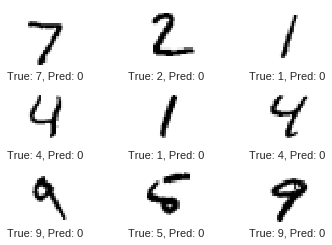

In [59]:
plot_example_errors()

In [0]:
#optimisation after one iteration
optimize(1)

In [63]:
print_accuracy()

Accuracy on test-set: 33.4%


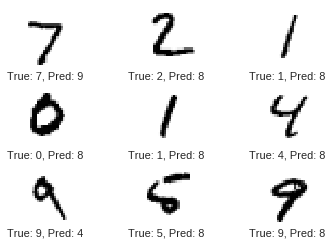

In [64]:
plot_example_errors()

In [0]:
optimize(100)

In [66]:
print_accuracy()

Accuracy on test-set: 85.5%


In [68]:
optimize(1000)

Accuracy on test-set: 84.4%
Accuracy on test-set: 83.7%
Accuracy on test-set: 86.5%
Accuracy on test-set: 85.0%
Accuracy on test-set: 86.6%
Accuracy on test-set: 90.0%
Accuracy on test-set: 81.2%
Accuracy on test-set: 81.1%
Accuracy on test-set: 88.1%
Accuracy on test-set: 88.5%


In [69]:
optimize(10000)

Accuracy on test-set: 88.7%
Accuracy on test-set: 86.4%
Accuracy on test-set: 86.8%
Accuracy on test-set: 89.1%
Accuracy on test-set: 86.7%
Accuracy on test-set: 86.4%
Accuracy on test-set: 89.0%
Accuracy on test-set: 76.0%
Accuracy on test-set: 88.7%
Accuracy on test-set: 88.6%
Accuracy on test-set: 87.4%
Accuracy on test-set: 88.5%
Accuracy on test-set: 90.4%
Accuracy on test-set: 89.2%
Accuracy on test-set: 89.6%
Accuracy on test-set: 86.9%
Accuracy on test-set: 90.6%
Accuracy on test-set: 88.4%
Accuracy on test-set: 87.9%
Accuracy on test-set: 85.1%
Accuracy on test-set: 89.8%
Accuracy on test-set: 86.8%
Accuracy on test-set: 90.9%
Accuracy on test-set: 89.0%
Accuracy on test-set: 90.5%
Accuracy on test-set: 75.8%
Accuracy on test-set: 85.4%
Accuracy on test-set: 80.2%
Accuracy on test-set: 88.1%
Accuracy on test-set: 89.5%
Accuracy on test-set: 89.5%
Accuracy on test-set: 87.1%
Accuracy on test-set: 89.3%
Accuracy on test-set: 89.1%
Accuracy on test-set: 89.4%
Accuracy on test-set

In [70]:
print_accuracy()

Accuracy on test-set: 90.0%


[[ 932    0    3    1    4    4   15    7   13    1]
 [   0 1102   10    0    0    1    2    2   18    0]
 [   4    5  949    4    9    1   14   14   29    3]
 [   6    2   64  763    2   81    6   25   51   10]
 [   1    2   13    1  901    0   10    9   10   35]
 [   8    5   18   12   14  737   23   10   59    6]
 [   6    2   12    1    4   11  916    2    4    0]
 [   0    6   30    2    9    1    0  943    4   33]
 [   2    9   40    8   12   13   12   16  845   17]
 [   4    8    2    5   31    6    3   27   13  910]]


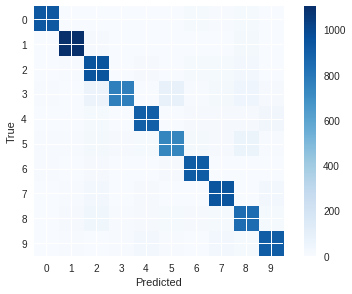

In [71]:
print_confusion_matrix()